# Mesh Node Temperature

**The Temperature of a Mesh Node After Diffusion Occurs:**
<p style="text-align: center;">$T_{i,j}^{t} = [\frac{1}{1+2\alpha{dt(\frac{1}{dx^2}+\frac{1}{dy^2})}}]\cdot[T_{i,j}^{t-1} + (\alpha{dt})(\frac{T_{i-1,j}^{t}+T_{i+1,j}^{t}}{dx^2}+\frac{T_{i,j-1}^{t}+T_{i,j+1}^{t}}{dy^2})]$</p>

**The Temperature of a Mesh Node After Being Heated by a Gaussian Distributed Laser:** 
<p style="text-align: center;">$T_n(x,y) = T_0(x,y) + \frac{q\cdot{dt}}{\rho{c_p}\pi\cdot(4\pi\alpha\cdot{dt})^{\frac{1}{2}}}\cdot\frac{1}{4\alpha\cdot{dt}+2\sigma^{2}}\cdot{e^{(-\frac{(x-x')^2+(y-y')^2}{2\sigma^2+4\alpha\cdot{dt}})}}$</p>


Initializing Variables...
Starting Calculations...
Half of Needed Calculations Completed...
Calculations Completed...
Animation Being Saved...
Making Frames...
Animation Saved in Present Working Directory With Name -  test.gif


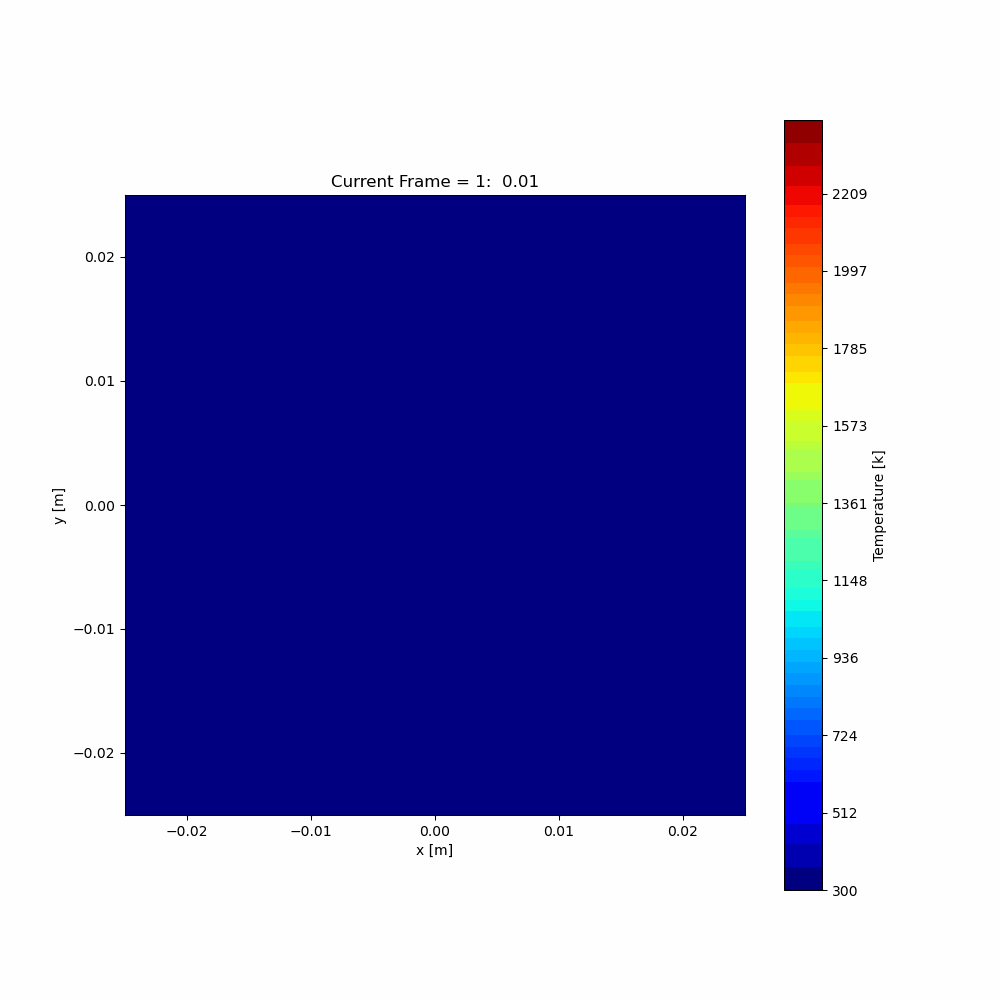

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import cm
from IPython import display
#################################################################################
# Input parameters:

# Plate Initialization:
x_length = 50/1000;               # [mm]-->[m]
y_length = 50/1000;               # [mm]-->[m]
nx = 200;                         # number of grid points
ny = 200;                         # number of grid points

# Plate Properties: Sample Material: AISI Type 316L Stainless Steel
T0 = 300; 			              # Initial ambient temperature [K]
k = 15; 			              # conductivity coefficient [W/m/K]
cp = .5*1000; 			          # specific heat [J/g/c]-->[J/kg/K]
rho = 8*1000; 		              # density [g/cc]-->[kg/m^3]

# Laser Initialization:
q = 300; 			              # laser power [W]
L_Rad = .7/1000;                  # Radius of the laser beam [mm] --> [m]
HSP =[.4*x_length,.4*x_length];   # Initial position of laser from plate center (x,y) [m]
vx = -20/1000; 	                  # laser speed x [m/s] (from [mm/sec])
vy = -20/1000; 	                  # laser speed y [m/s]

# Simulation Options: 
Max_Time = 3;                     # Time simulated [s]
Data_points = 400;                # amount of data sets collected
Frames_Used = 100;                # Frames seen (Should evenly devide Data points)
Temp_Definition  = 200;           # Levels of temperature displayed on figure

file_name = 'test.gif'

#################################################################################

print('Initializing Variables...')
[x,y] = np.meshgrid(np.linspace(-x_length/2,x_length/2,nx),np.linspace(-y_length/2,y_length/2,ny)); # [m]

dt = Max_Time/Data_points;                       # initialize values needed for calculations
alpha = k/(rho*cp);                              # dt = change in time per step
x_area = (x_length/nx)**2                        # alpha is the thermal diffusivity (m^2/s)
y_area = (y_length/ny)**2                        # the area of heat flow is represented by x_area or y_area

Time = np.linspace(0,Max_Time,Data_points);      # initialize the arrays used for data storage
T_diff =np.zeros((nx-1,ny-1));                   # T_diff stores the temperature distribution after diffusion      
T = T0*np.ones((nx,ny));                         # T stores the Temperature distribution after the laser heat gen.
Trial_Temps = list();                            # Trial_Temps stores temperature distributions from all trials

print('Starting Calculations...')
for t in range(np.size(Time)):
  T_pre = T;
  Trial_Temps.append(np.copy(T))  # store the previous temperature distribution
    
  for i in range(1,ny-1,1): # diffusion
    for j in range(1,nx-1,1):
       T_diff[i][j]= (1/(1+2*alpha*dt*((1/x_area)+(1/y_area))))*(T_pre[i][j]+(alpha*dt)*(((T[i-1][j]+T[i+1][j])/x_area)+((T[i][j-1]+T[i][j+1])/y_area)));
            
  for i in range(1,ny-1,1): # heat generated by the laser
    for j in range(1,nx-1,1):
      q_dt = q*dt; #Laser strength [J]
      Denom_Out = 2*np.pi*rho*cp*((4*np.pi*alpha*dt)**(1/2))*(2*alpha*dt+L_Rad**2);
      Num_xy = ((x[i][j]-HSP[0])**2)+((y[i][j]-HSP[1])**2);
      Denom_xy = 4*alpha*dt + 2*(L_Rad**2);
      T[i][j] = T_diff[i][j] + ((q_dt)/Denom_Out)*np.exp(-(Num_xy/Denom_xy)); #calcs the temp at point i,j
  
  HSP[0] = HSP[0]+vx*dt; #update the laser position
  HSP[1] = HSP[1]+vy*dt;

  if t == int(Data_points/2):
      print('Half of Needed Calculations Completed...')
T_Max = np.max(np.max(Trial_Temps));
print('Calculations Completed...')

#################################################################################

fig = plt.figure()
fig.set_figheight(10)
fig.set_figwidth(10)
ax = plt.axes(xlim=(-x_length/2, x_length/2), ylim=(-y_length/2, y_length/2),xlabel='x [m]',ylabel='y [m]')
ax.set_aspect('equal', 'box')
cvals = np.linspace(T0,T_Max,Temp_Definition)     # set contour values 
cont = plt.contourf(x, y, Trial_Temps[0], cvals,cmap = cm.jet)    # first image on screen
plt.colorbar(cont,label = 'Temperature [k]', orientation="vertical")

n = int(Data_points/Frames_Used);

# animation function
def animate(dp):        # the function required for animation creation
    global cont,n
    T_Array = Trial_Temps[dp*n] # retrieve the saved data
    for c in cont.collections:
        c.remove()  # removes only the contours, leaves the rest intact
    cont = plt.contourf(x, y, T_Array, cvals,cmap = cm.jet)
    plt.title('Current Frame = %i:  %.2f' % (dp+1,Time[int((n*dp)+1)]))
    return cont

print('Animation Being Saved...')
anim = animation.FuncAnimation(fig,animate,frames=Frames_Used,cache_frame_data = False); # makes the animation
writergif = animation.PillowWriter(n); # creates a gif writter
print('Making Frames...')
anim.save(file_name,writer=writergif); # saves the gif
print('Animation Saved in Present Working Directory With Name - ', file_name)
plt.close()
display.Image(file_name) # displays the gif